In [1]:
import numpy as np
import pandas as pd
import os

PIC_DIR = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
len(os.listdir(PIC_DIR))

202599

In [2]:
from PIL import Image
from tqdm import tqdm

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

images = np.array(images) / 255
images.shape

100%|██████████| 10000/10000 [01:12<00:00, 137.86it/s]


(10000, 128, 128, 3)

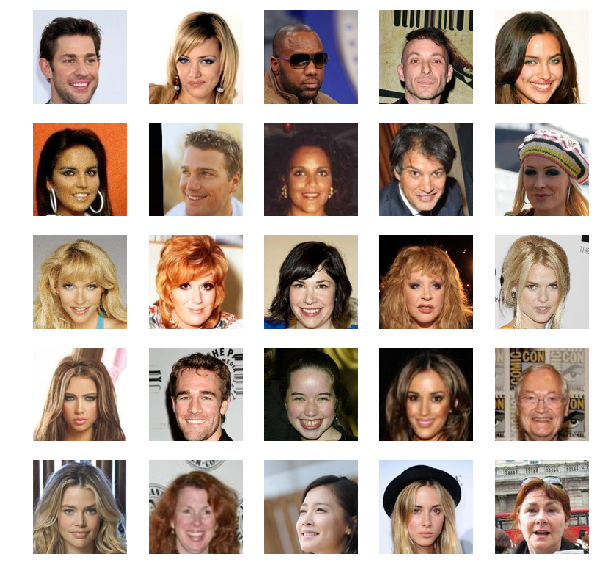

In [3]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = tf.keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(128 * 16 * 16)(gen_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    generator = tf.keras.Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
    x = layers.Conv2D(256, 3)(disc_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = tf.keras.Model(disc_input, x)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
    return discriminator

In [5]:
generator = create_generator()
discriminator = create_discriminator()  # Specify height and width

discriminator.trainable = False

gan_input = tf.keras.Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)

optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
import time
from datetime import datetime
import matplotlib.pyplot as plt

iters = 20000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'

if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    start_time = time.time()

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size

    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('gan.h5')
        print('%d/%d: d_loss: %.4f, a_loss: %.4f. (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]

        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

        # Plot the generated images
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        for i in range(5):
            ax[i].imshow(control_generated[i].squeeze(), cmap='gray')
            ax[i].axis('off')
        plt.show()

        # Plot the discriminator and generator losses
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(d_losses)
        plt.title('Discriminator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(a_losses)
        plt.title('Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.show()

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

In [ ]:
gan